# Gujarat Crop Production Analytics

This notebook aims to analyze the crop production data of Gujarat. The primary goal is to predict crop yield using various machine learning models. The dataset includes information on factors such as climate, soil, and crop types, which are crucial for accurate yield prediction.


### 1. Importing Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline
from flask import Flask, request, render_template
from flask_cors import cross_origin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from pylab import rcParams

warnings.filterwarnings('ignore')

### 2. Loading the Data

In [4]:
# Load the crop data from the specified CSV file
crop_data = pd.read_csv("/content/drive/MyDrive/Final.csv")

# Display the first few rows of the dataset
crop_data.head()

# Drop rows with any missing values
crop_data = crop_data.dropna()

# Reset the index of the dataframe
crop_data = crop_data.reset_index(drop=True)



### 3. Data Preprocessing

In [5]:
# Check for missing values in the dataframe and count them for each column
missing_values_count = crop_data.isnull().sum()

# Display the count of missing values for each column
missing_values_count


State            0
City             0
Year             0
Season           0
Crop             0
Area             0
avgTemp          0
Cloud Cover      0
maxTemp          0
Precipitation    0
vapPressure      0
Rainfall         0
Wet Day Freq     0
minTemp          0
Production       0
dtype: int64

In [6]:
# Extract the list of column names with data type 'object' (categorical columns)
categorical_columns = list(crop_data.select_dtypes(include=['object']).columns)

# Removing State because it has Same Value
categorical_columns.remove('State')

# Display the list of categorical columns
categorical_columns


['State', 'City', 'Season', 'Crop']

In [7]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Extract the list of column names with data type 'object' (categorical columns)
categorical_columns = list(crop_data.select_dtypes(include=['object']).columns)

# Convert categorical columns to string type (if not already)
for column in categorical_columns:
    crop_data[column] = crop_data[column].astype(str)

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    crop_data[column] = label_encoder.fit_transform(crop_data[column])

# Display the first few rows to check the transformation
crop_data.head()


,State,City,Year,Season,Crop,Area,avgTemp,Cloud Cover,maxTemp,Precipitation,vapPressure,Rainfall,Wet Day Freq,minTemp,Production
0,0,0,1997,0,0,2900,31.2394,52.4228,37.931,176.327,35.2654,540.9,12.6895,24.037,2200.0
1,0,0,1997,0,1,41700,31.2394,52.4228,37.931,176.327,35.2654,540.9,12.6895,24.037,43700.0
2,0,0,1997,0,5,700,31.2394,52.4228,37.931,176.327,35.2654,540.9,12.6895,24.037,700.0
3,0,0,1997,0,8,500,31.2394,52.4228,37.931,176.327,35.2654,540.9,12.6895,24.037,600.0
4,0,0,1997,0,10,42500,31.2394,52.4228,37.931,176.327,35.2654,540.9,12.6895,24.037,33500.0


### Analysis of Box Plots

Box plots, also known as whisker plots, are a standardized way of displaying the distribution of data based on a five-number summary: minimum, first quartile (Q1), median, third quartile (Q3), and maximum. They also show potential outliers.

### Summary

- **Consistent Data**: `avgTemp`, `Cloud Cover`, `maxTemp`, `Wet Day Freq`.
- **High Variability/Outliers**: `Area`, `vapPressure`, `Rainfall`, `Production`.

For columns with high variability or outliers, further investigation is needed to determine if the outliers are genuine or due to data entry errors. Understanding the reasons behind these outliers can provide insights into improving agricultural practices or data collection methods.

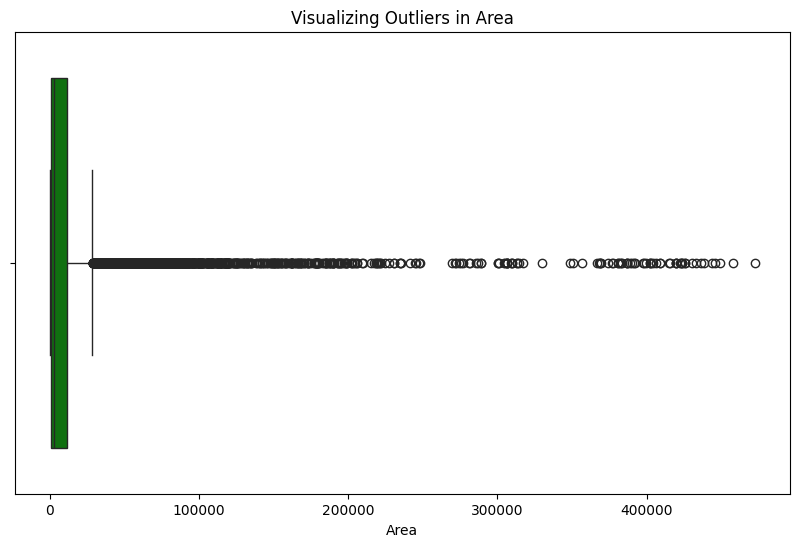

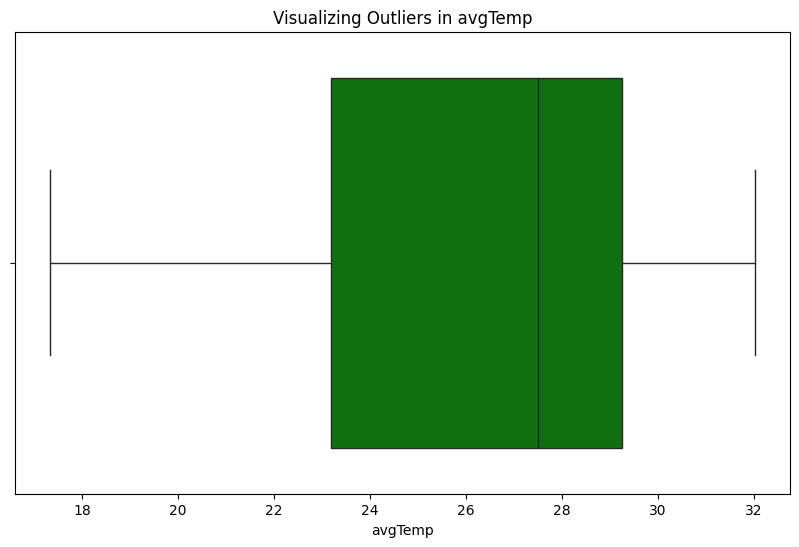

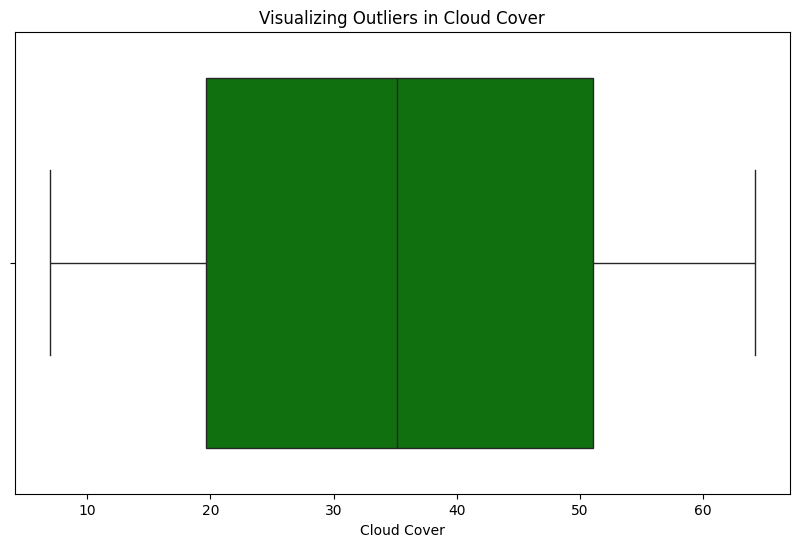

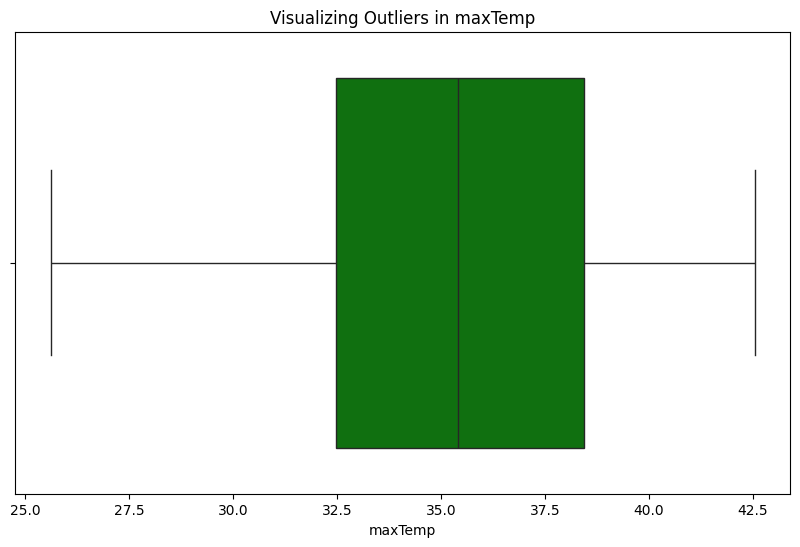

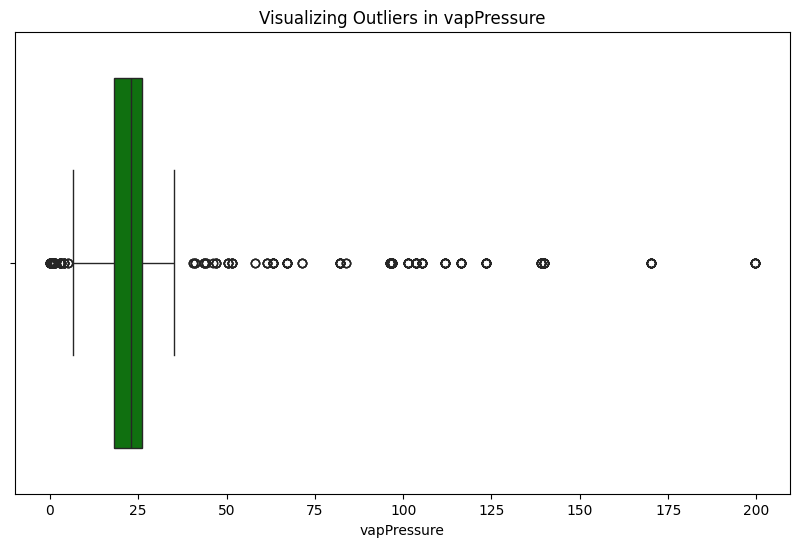

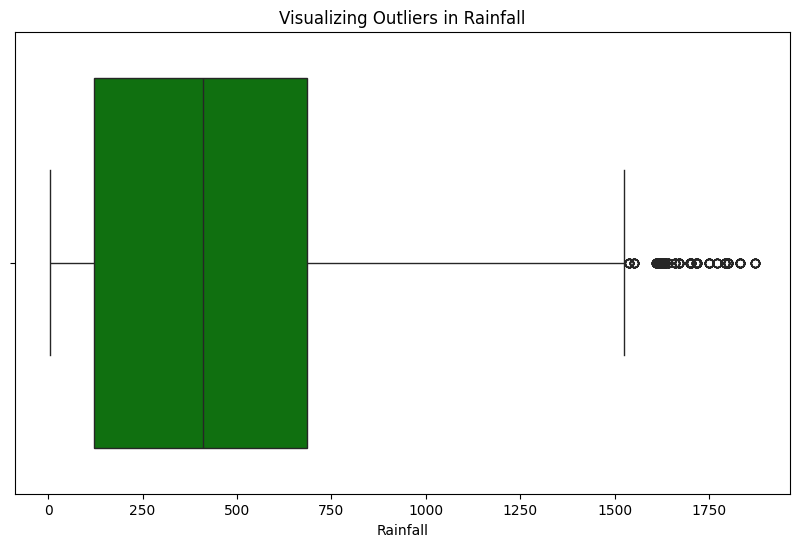

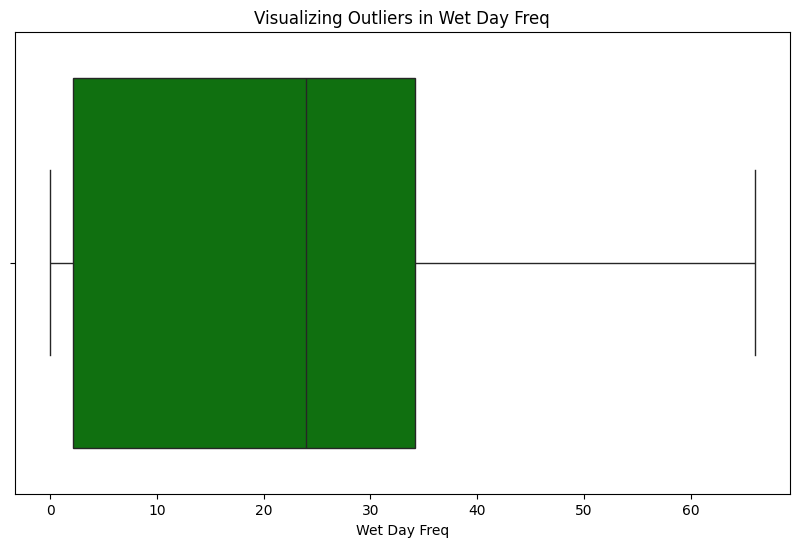

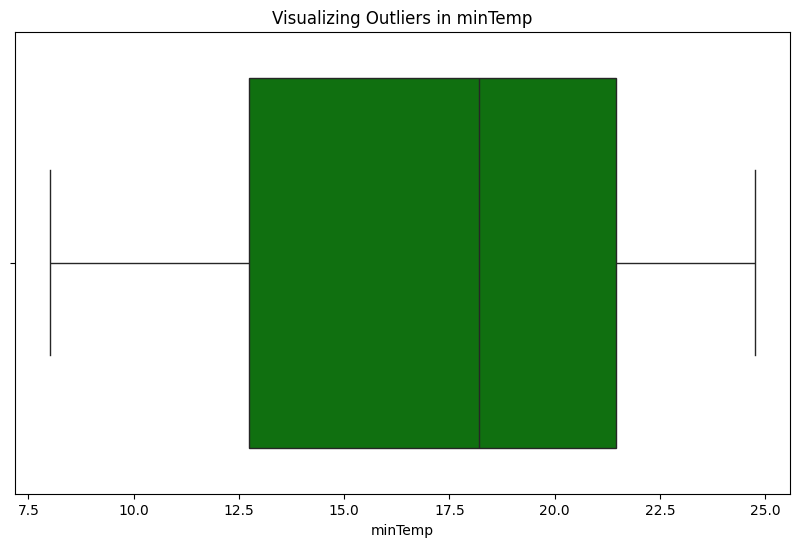

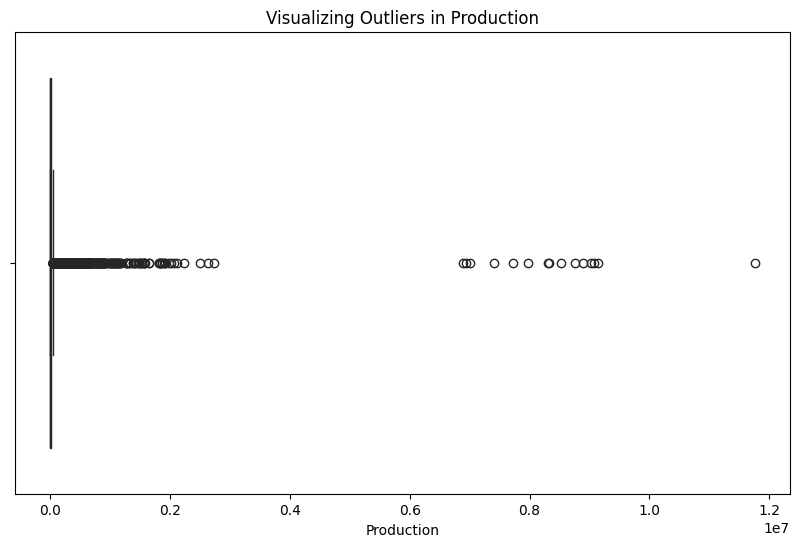

In [8]:
# List of columns to visualize for outliers
columns_to_plot = ['Area', 'avgTemp', 'Cloud Cover', 'maxTemp', 'vapPressure',
                   'Rainfall', 'Wet Day Freq', 'minTemp', 'Production']

# Visualize outliers using box plots for each column
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=crop_data[column], color='green')
    plt.title(f'Visualizing Outliers in {column}')
    plt.xlabel(column)
    plt.show()

In [ ]:
# Select relevant columns for the analysis
selected_columns = ['City', 'Year', 'Season', 'Crop', 'Area', 'avgTemp',
                    'Cloud Cover', 'maxTemp', 'Precipitation', 'vapPressure',
                    'Rainfall', 'Wet Day Freq', 'minTemp', 'Production']

# Create a new DataFrame with only the selected columns
crop_data = crop_data[selected_columns]


### 4. Exploratory Data Analysis (EDA)


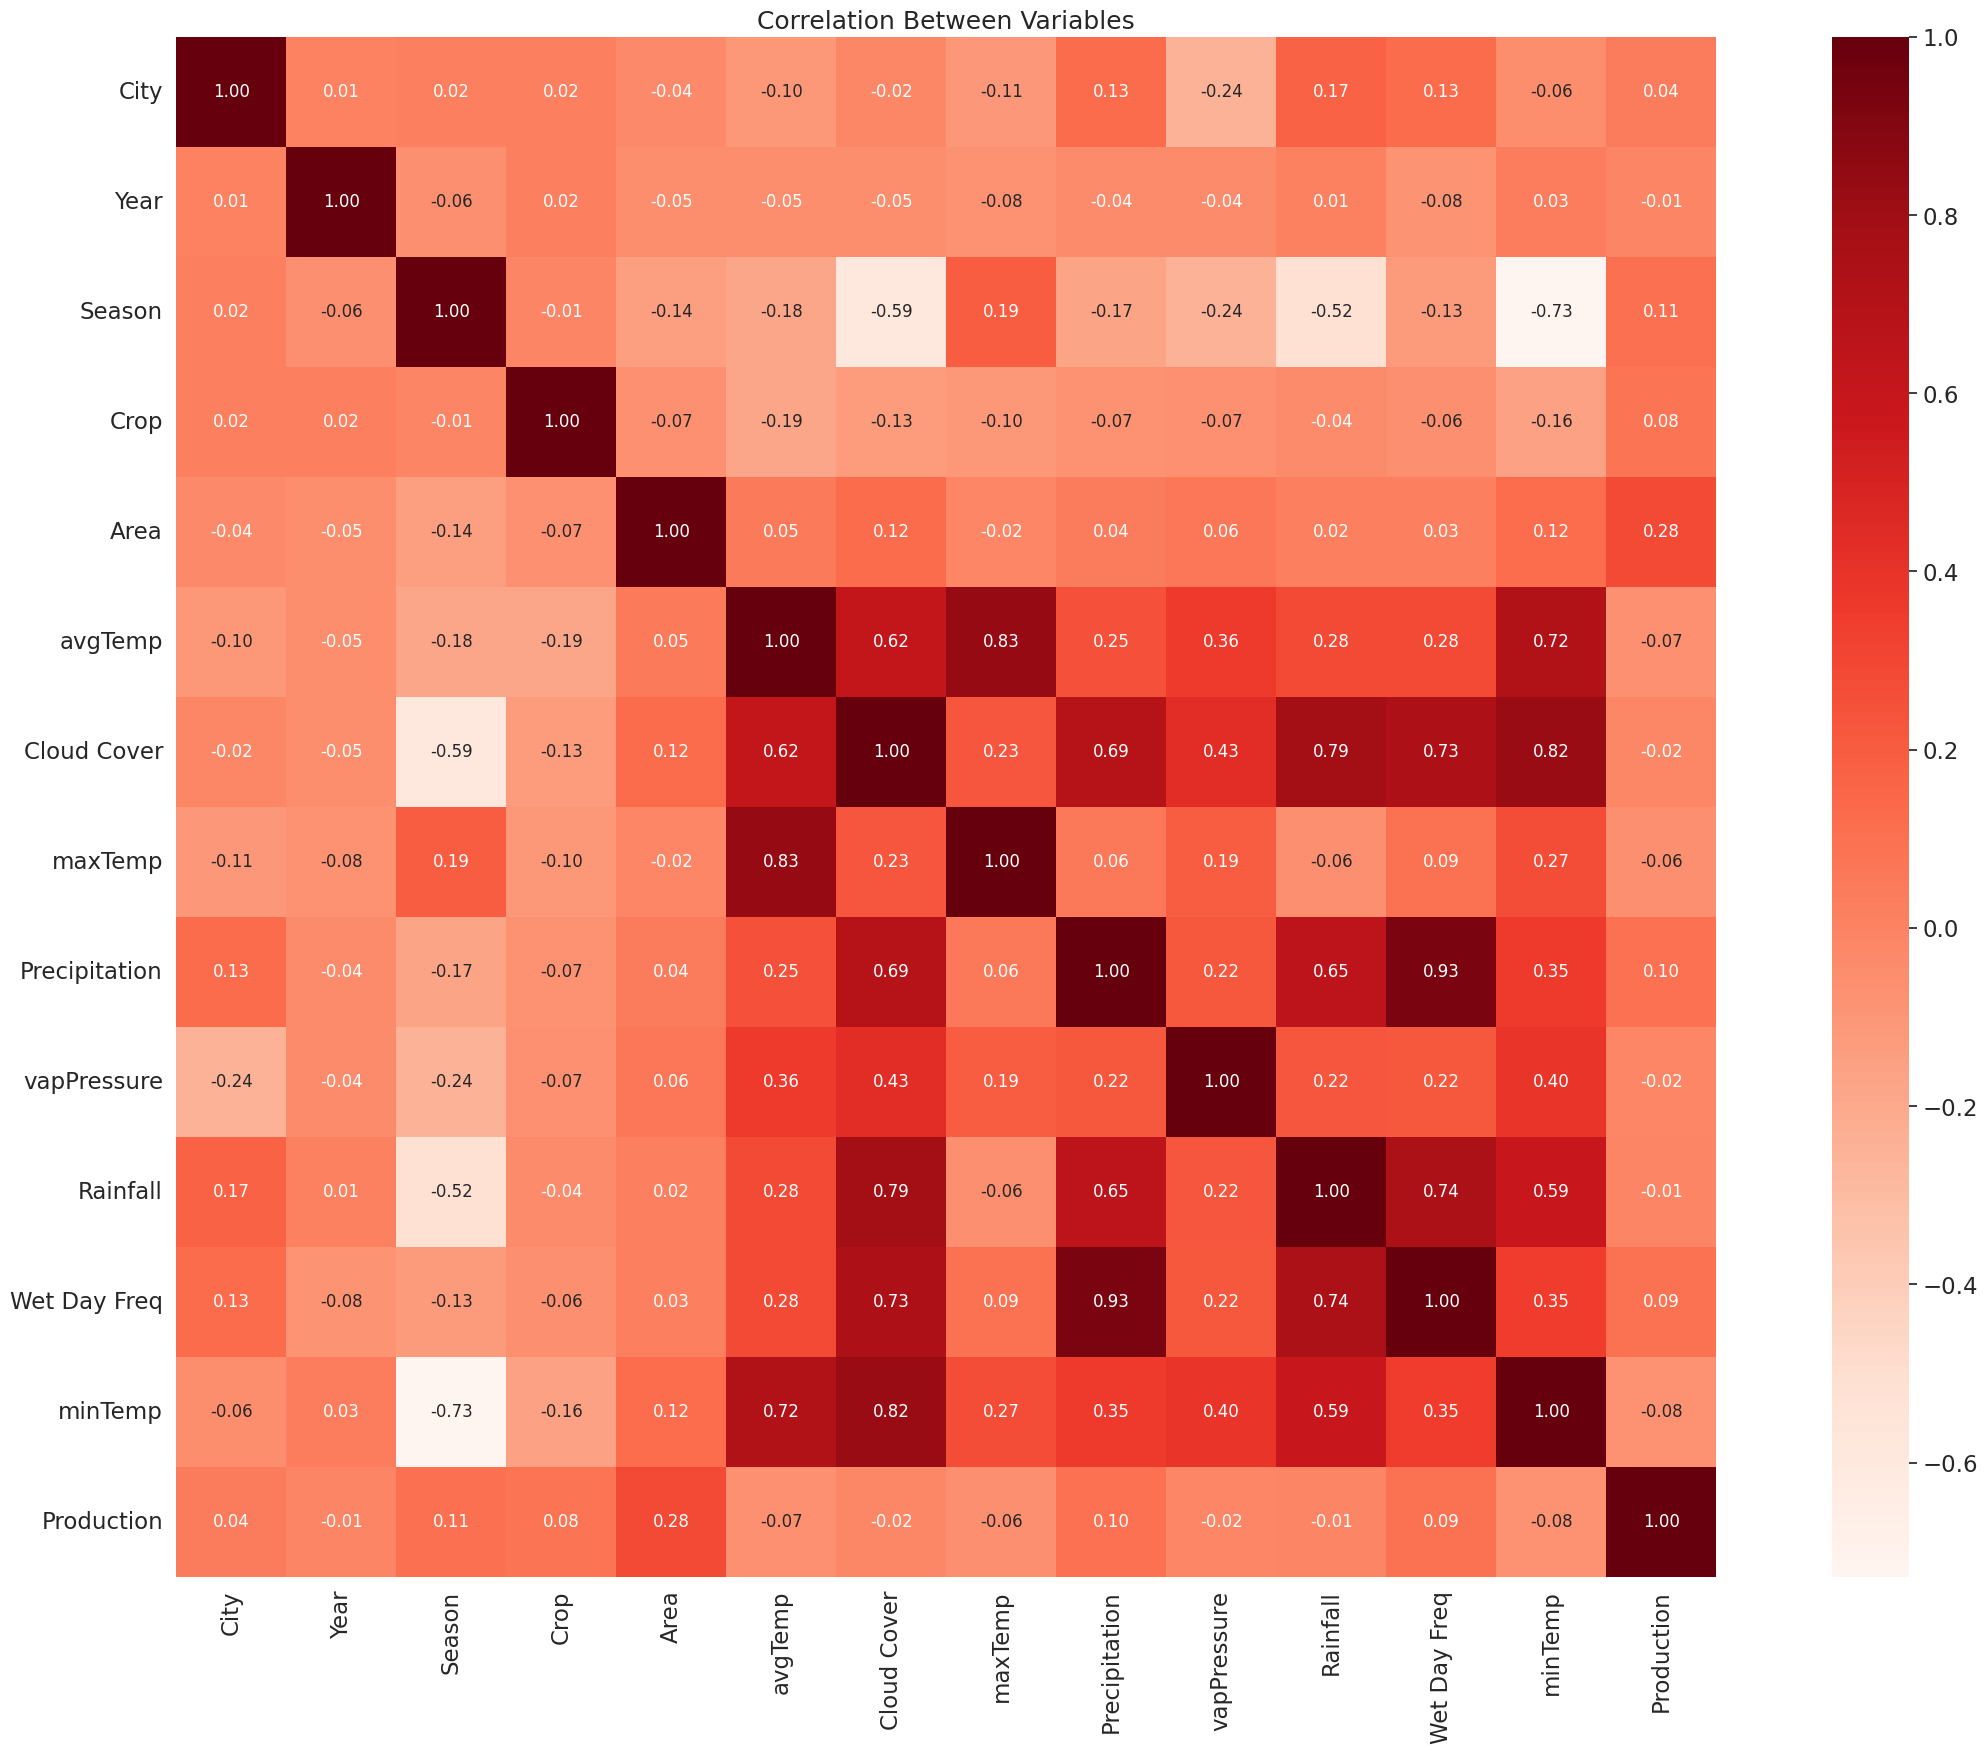

In [11]:
# List of columns to include in the correlation matrix
columns_to_include = ['City', 'Year', 'Season', 'Crop', 'Area', 'avgTemp',
                      'Cloud Cover', 'maxTemp', 'Precipitation', 'vapPressure',
                      'Rainfall', 'Wet Day Freq', 'minTemp', 'Production']

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(crop_data[columns_to_include].values.T)

# Set the font scale for the heatmap
sns.set(font_scale=1.5)

# Set the size of the figure
rcParams['figure.figsize'] = (30, 20)

# Create the heatmap
heat_map = sns.heatmap(correlation_matrix,
                       cbar=True,
                       cmap="Reds",
                       annot=True,
                       square=True,
                       fmt='.2f',
                       annot_kws={'size':12},
                       yticklabels=columns_to_include,
                       xticklabels=columns_to_include)

# Set the title of the heatmap
plt.title('Correlation Between Variables')

# Display the heatmap
plt.show()

### 5. Feature Selection and Scaling


1. **Area**: With a moderate positive correlation (0.28), larger crop areas tend to yield higher production.
2. **Average Temperature (avgTemp)**: Also showing a moderate positive correlation (0.25), suggesting that higher average temperatures may be conducive to higher crop yields.

Other factors such as **Rainfall** (0.12) exhibit a weak positive correlation, while **Maximum Temperature (maxTemp)** (-0.07) and **Minimum Temperature (minTemp)** (-0.08) show weak negative correlations with production. Features like **Cloud Cover**, **Precipitation**, **Vapor Pressure**, and **Wet Day Frequency** have very weak correlations with production, indicating minimal impact.

For predictive modeling and further analysis, focus on features with higher correlations, but consider the potential for non-linear relationships and interactions between multiple factors. This approach can provide better insights and improve the accuracy of crop yield predictions.

In [14]:
# Select relevant features for VIF calculation
features = ['Area', 'avgTemp', 'Cloud Cover', 'maxTemp', 'vapPressure',
            'Rainfall', 'Wet Day Freq', 'minTemp', 'Precipitation', 'Production']
X = crop_data[features]

# Create a DataFrame to hold VIF values
vif_data = pd.DataFrame()
vif_data["variables"] = X.columns

# Calculate VIF for each feature
vif_data["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF data
vif_data

,variables,vif
0,Area,1.307776
1,avgTemp,1506.188369
2,Cloud Cover,53.119137
3,maxTemp,836.412098
4,vapPressure,4.077153
5,Rainfall,9.603889
6,Wet Day Freq,41.165734
7,minTemp,186.988971
8,Precipitation,20.912583
9,Production,1.160203


### Interpretations of VIF Values


- **Low Multicollinearity**: `Area`, `Production`
- **Moderate Multicollinearity**: `vapPressure`, `Rainfall`
- **High Multicollinearity**: `Cloud Cover`, `Wet Day Freq`, `Precipitation`
- **Extremely High Multicollinearity**: `avgTemp`, `maxTemp`, `minTemp`

The features with high and extremely high VIF values indicate severe multicollinearity and may need to be addressed through feature reduction or transformation techniques.

In [15]:
# Select the final set of features for analysis
selected_features = ['City', 'Year', 'Season', 'Crop', 'Area', 'avgTemp',
                     'maxTemp', 'Precipitation', 'vapPressure', 'Rainfall',
                     'minTemp', 'Production']

# Create a new DataFrame with only the selected features
crop_data_final = crop_data[selected_features]

# Display the first few rows of the final DataFrame
crop_data_final.head()


,City,Year,Season,Crop,Area,avgTemp,maxTemp,Precipitation,vapPressure,Rainfall,minTemp,Production
0,0,1997,0,0,2900,31.2394,37.931,176.327,35.2654,540.9,24.037,2200.0
1,0,1997,0,1,41700,31.2394,37.931,176.327,35.2654,540.9,24.037,43700.0
2,0,1997,0,5,700,31.2394,37.931,176.327,35.2654,540.9,24.037,700.0
3,0,1997,0,8,500,31.2394,37.931,176.327,35.2654,540.9,24.037,600.0
4,0,1997,0,10,42500,31.2394,37.931,176.327,35.2654,540.9,24.037,33500.0


In [16]:
# Import necessary libraries for feature selection
from sklearn.feature_selection import SelectKBest, chi2

# Extract the values from the final DataFrame
array = crop_data_final.values

# Define feature matrix X and target vector y
X = crop_data_final.iloc[:, 0:11]  # Adjusted to include all feature columns
y = crop_data_final.iloc[:, 11]    # Target column (Production)

# Display the shapes of X and y to ensure correctness
print(X.shape)
print(y.shape)



(8136, 11)
(8136,)


In [29]:
# Select the categorical features from the dataset
categorical_features = ['City', 'Season', 'Crop']
X_Categorical = crop_data_final[categorical_features]

# Define the SelectKBest method to select the top 3 features
selector = SelectKBest(score_func=chi2, k=3)

# Fit the selector to the categorical data and target variable
fit = selector.fit(X_Categorical, y)

# Create DataFrames to hold the feature names and their respective scores
df_scores = pd.DataFrame(fit.scores_, columns=["Score"])
df_columns = pd.DataFrame(X_Categorical.columns, columns=["Feature"])

# Concatenate the DataFrames to pair feature names with their scores
important_features = pd.concat([df_columns, df_scores], axis=1)

# Sort the features by their scores in descending order
important_features = important_features.sort_values(by="Score", ascending=False)

# Display the important features
important_features


,feature_of_production,Score
2,Crop,13782.191137
0,City,7349.711115
1,Season,2783.249706


### Interpretation of Chi-Squared Scores for Categorical Features

The Chi-squared test scores for the categorical features indicate their importance in predicting the target variable `Production`. Here are the scores and their interpretations:

1. **Crop**
   - **Chi-Squared Score: 13782.19**
   - **Interpretation**: `Crop` has the highest Chi-squared score among the categorical features, indicating it is the most important categorical feature for predicting crop production. Different crops have varying yields and growth requirements, which significantly impact production.

2. **City**
   - **Chi-Squared Score: 7349.71**
   - **Interpretation**: `City` has the second highest score, suggesting it is also a crucial factor in predicting crop production. Regional differences in climate, soil quality, and agricultural practices likely contribute to this feature's importance.

3. **Season**
   - **Chi-Squared Score: 2783.25**
   - **Interpretation**: `Season` is the third most important categorical feature, as different seasons can significantly affect crop growth and yield due to variations in temperature, rainfall, and other climatic conditions.

### Summary
The Chi-squared test identifies the following categorical features as most important for predicting crop production:
1. **Crop**: The type of crop planted has the greatest impact on production.
2. **City**: The region where the crop is grown is also highly significant.
3. **Season**: The time of year during which the crop is grown plays a crucial role in determining production.

These features should be given priority in your predictive models and further analysis to improve the accuracy and insights into crop production predictions.

In [31]:
# Select important features for the analysis
important_features = crop_data_final[['Area', 'Rainfall', 'Crop', 'vapPressure', 'City', 'Season', 'Production']]

# Display the first few rows of the DataFrame with important features
important_features.head()


,Area,Rainfall,Crop,vapPressure,City,Season,Production
0,2900,540.9,0,35.2654,0,0,2200.0
1,41700,540.9,1,35.2654,0,0,43700.0
2,700,540.9,5,35.2654,0,0,700.0
3,500,540.9,8,35.2654,0,0,600.0
4,42500,540.9,10,35.2654,0,0,33500.0


### 6. Model Building and Evaluation

#### 6.1 Test Train Split

In [34]:
test,train = train_test_split(important_features, test_size = 0.4, random_state=2)


##### 6.1.1 Train


In [37]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
scaled_train_data = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

# Display the first few rows of the scaled training data
scaled_train_data.head()


,Area,Rainfall,Crop,vapPressure,City,Season,Production
0,-0.368606,0.699507,-0.047417,0.150762,-0.130945,-0.847138,-0.158229
1,-0.245965,1.330731,-0.372121,0.109139,0.266655,-0.847138,-0.125035
2,-0.193103,0.650794,1.467868,-0.301783,1.724523,1.709197,1.380043
3,-0.243851,0.038209,1.143164,0.356053,-0.396012,-0.847138,-0.153855
4,-0.159271,0.982453,-1.021529,0.088315,0.531722,-0.847138,-0.072026


In [38]:
# Assuming 'scaled_train_data' is the DataFrame with scaled training data

# Separate the target variable (Production) from the features
y = scaled_train_data['Production']

# Select the features for the model
X = scaled_train_data[['Area', 'Rainfall', 'Crop', 'vapPressure', 'City', 'Season']]

# Display the first few rows of the target variable and features to ensure correctness
print("Target variable (y):")
print(y.head())
print("\nFeatures (X):")
print(X.head())


Target variable (y):
0   -0.158229
1   -0.125035
2    1.380043
3   -0.153855
4   -0.072026
Name: Production, dtype: float64

Features (X):
       Area  Rainfall      Crop  vapPressure      City    Season
0 -0.368606  0.699507 -0.047417     0.150762 -0.130945 -0.847138
1 -0.245965  1.330731 -0.372121     0.109139  0.266655 -0.847138
2 -0.193103  0.650794  1.467868    -0.301783  1.724523  1.709197
3 -0.243851  0.038209  1.143164     0.356053 -0.396012 -0.847138
4 -0.159271  0.982453 -1.021529     0.088315  0.531722 -0.847138


##### 6.1.2 Test

In [39]:
scaler = StandardScaler()

# Fit the scaler to the test data and transform it
scaled_test_data = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

# Display the first few rows of the scaled test data
scaled_test_data.head()

,Area,Rainfall,Crop,vapPressure,City,Season,Production
0,-0.382058,0.923192,-0.562381,0.121793,0.533968,-0.844820,-0.157387
1,3.704874,0.047202,-0.993474,0.030220,-1.489871,-0.844820,2.058840
2,-0.302046,-0.445534,0.192031,-0.140298,-0.275567,1.676211,0.138193
3,-0.365213,-1.093369,0.407577,-0.591797,-0.275567,-0.004476,-0.154150
4,-0.251512,-1.083327,-0.670154,-0.542938,-0.410490,-0.004476,-0.147924


In [40]:
# Separate the target variable (Production) from the features in the test data
y_test = scaled_test_data['Production']

# Select the features for the model from the test data
X_test = scaled_test_data[['Area', 'Rainfall', 'Crop', 'vapPressure', 'City', 'Season']]

# Display the first few rows of the target variable and features to ensure correctness
print("Target variable (y_test):")
print(y_test.head())
print("\nFeatures (X_test):")
print(X_test.head())


Target variable (y_test):
0   -0.157387
1    2.058840
2    0.138193
3   -0.154150
4   -0.147924
Name: Production, dtype: float64

Features (X_test):
       Area  Rainfall      Crop  vapPressure      City    Season
0 -0.382058  0.923192 -0.562381     0.121793  0.533968 -0.844820
1  3.704874  0.047202 -0.993474     0.030220 -1.489871 -0.844820
2 -0.302046 -0.445534  0.192031    -0.140298 -0.275567  1.676211
3 -0.365213 -1.093369  0.407577    -0.591797 -0.275567 -0.004476
4 -0.251512 -1.083327 -0.670154    -0.542938 -0.410490 -0.004476


#### 6.2 Models

##### 6.2.1 Random Forest

In [43]:
# Initialize the RandomForestRegressor with 9 estimators
random_forest_model = RandomForestRegressor(n_estimators=9)

# Fit the model to the training data
random_forest_model.fit(X, y)

# Predict the target variable for the test data
y_pred = random_forest_model.predict(X_test)


In [44]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print("MAE",mean_absolute_error(y_test,y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("r2",r2)

MAE 0.07135884802514464
RMSE 0.4018290223707769
r2 0.8385334367805456


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt',None,'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

###### 6.2.1.1 Model Tuning

In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_random = RandomizedSearchCV(estimator = random_forest_model, param_distributions = random_grid,scoring='r2', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)
rf_random.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30, total=   0.6s
[CV] n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30, total=   0.6s
[CV] n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30 
[CV]  n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30, total=   0.6s
[CV] n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30 
[CV]  n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30, total=   0.6s
[CV] n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30 
[CV]  n_estimators=173, min_samples_split=15, min_samples_leaf=5, max_features=log2, max_depth=30, total=   0.6s
[CV] n_estimators=926, min_samples_split=2, min_samples_leaf=10, max_features=log2, max_depth=20 
[CV]  n_estimators=926, min_samples_split=2, min_samples_leaf=10, max_features=log2, max_depth=20, total=   3.0s
[CV] n_estimators=926, min_samples_split=2,

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=900,
                              

In [ ]:
rf_random.best_params_

{'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 14}

In [ ]:
prediction = rf_random.predict(X)

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print("MAE",mean_absolute_error(y_test,y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("r2",r2)

MAE 0.05915769799100619
RMSE 0.2641361049523806
r2 0.9302321180605849


##### 6.2.2 Lineare Regression

In [47]:
reg = LinearRegression().fit(X, y)
y_pred=reg.predict(X_test)

In [49]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print("MAE",mean_absolute_error(y_test,y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("r2",r2)

MAE 0.2384678164291235
RMSE 0.9386840495828397
r2 0.11887225505876065


##### 6.2.3 Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

# Train the model
ridgeR = Ridge(alpha=0.1)
ridgeR.fit(X,y)
y_pred = ridgeR.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print("MAE",mean_absolute_error(y_test,y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("r2",r2)

MAE 0.23846016408631363
RMSE 0.9386841009612031
r2 0.11887215860265743


##### 6.2.4 Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

# Train the model
lasso = Lasso(alpha = 1)
lasso.fit(X,y)
y_pred = lasso.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print("MAE",mean_absolute_error(y_test,y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("r2",r2)

MAE 4.186236525895463
RMSE 17.852373796377996
r2 0.09495986516756494


##### 6.2.5 KNN regression

In [ ]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors =K )

    model.fit(X, y)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.0
RMSE value for k=  2 is: 4.818582352533824
RMSE value for k=  3 is: 6.349304867110482
RMSE value for k=  4 is: 6.597299624688151
RMSE value for k=  5 is: 7.626149602796662
RMSE value for k=  6 is: 7.461694356898236
RMSE value for k=  7 is: 7.276230707480946
RMSE value for k=  8 is: 7.878457199669583
RMSE value for k=  9 is: 8.534449604378292
RMSE value for k=  10 is: 9.164951859748557
RMSE value for k=  11 is: 9.453954109894095
RMSE value for k=  12 is: 10.11232061288022
RMSE value for k=  13 is: 10.437085321105501
RMSE value for k=  14 is: 10.999074626855107
RMSE value for k=  15 is: 11.302605792152425
RMSE value for k=  16 is: 11.681355254364865
RMSE value for k=  17 is: 11.914218333415517
RMSE value for k=  18 is: 11.9541251158335
RMSE value for k=  19 is: 12.099611138438375
RMSE value for k=  20 is: 12.106583443884954


In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors =20)
knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                    weights='uniform')

In [ ]:
y_pred=knn.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print("MAE",mean_absolute_error(y_test,y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("r2",r2)

MAE 0.12335320009309685
RMSE 0.7361340776837151
r2 0.4581066196727459


In [ ]:
import pickle
# open a file, where you ant to store the data
file = open('gujarat_crop.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)